In [1]:
!apt-get install -y tesseract-ocr tesseract-ocr-hin tesseract-ocr-ben
!apt-get install -y tesseract-ocr-chi-sim tesseract-ocr-chi-tra
!apt-get install -y tesseract-ocr-ara tesseract-ocr-urd
!apt-get install -y poppler-utils
!pip install -q pytesseract pdf2image PyPDF2 pymupdf sentence-transformers
!pip install -q langchain chromadb faiss-cpu rank-bm25 transformers accelerate bitsandbytes
!pip install -q langdetect pandas matplotlib seaborn pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  tesseract-ocr-ben tesseract-ocr-hin
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,428 kB of archives.
After this operation, 2,008 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ben all 1:4.00~git30-7274cfa-1.1 [516 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-hin all 1:4.00~git30-7274cfa-1.1 [913 kB]
Fetched 1,428 kB in 2s (634 kB/s)
Selecting previously unselected package tesseract-ocr-ben.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-ben_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-ben (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-

In [2]:
from google.colab import userdata
token = userdata.get('HF_token')

In [3]:
from huggingface_hub import login
login(token=token)

In [11]:
# =============================================================================
# COMPLETE MULTILINGUAL PDF RAG SYSTEM
# Combines OCR, Arabic/Urdu support, and comprehensive benchmarking
# Optimized for Google Colab with efficient, free tools
# =============================================================================

# SECTION 1: INSTALLATION AND SETUP
# =============================================================================
"""
Run this cell first to install all required dependencies
"""

# Uncomment and run in Google Colab:
"""

"""

print("✓ All dependencies installed successfully!")

# =============================================================================
# SECTION 2: IMPORTS
# =============================================================================

import os
import json
import time
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# PDF Processing
import PyPDF2
import fitz  # PyMuPDF
import pytesseract
from pdf2image import convert_from_path
from PIL import Image

# NLP and Embeddings
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
import langdetect
from langdetect import detect_langs, LangDetectException

# Vector Store
import chromadb
from chromadb.config import Settings
import faiss
import numpy as np

# Reranking
from rank_bm25 import BM25Okapi

# LLM
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

# Evaluation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# SECTION 3: CONFIGURATION
# =============================================================================

@dataclass
class RAGConfig:
    """Configuration for the RAG system"""

    # Multilingual embedding model (supports 50+ languages including Arabic/Urdu)
    embedding_model: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

    # LLM with multilingual support
    llm_model: str = "google/gemma-2-2b-it"

    # Chunking Configuration
    chunk_size: int = 512
    chunk_overlap: int = 100

    # Retrieval Configuration
    top_k_retrieval: int = 20
    top_k_rerank: int = 5

    # Vector Store
    vector_db_path: str = "./chroma_db"

    # OCR Configuration - Complete language support
    ocr_languages: str = "eng+hin+ben+chi_sim+chi_tra+ara+urd"
    ocr_confidence_threshold: float = 60.0

    # Performance
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size: int = 32

config = RAGConfig()
print(f"✓ Configuration loaded. Using device: {config.device}")

# =============================================================================
# SECTION 4: ENHANCED PDF EXTRACTION WITH COMPLETE OCR SUPPORT
# =============================================================================

class PDFExtractor:
    """Extract text from digital and scanned PDFs with OCR support"""

    def __init__(self, ocr_languages: str = "eng+hin+ben+chi_sim+ara+urd"):
        self.ocr_languages = ocr_languages
        self.digital_methods = [self._extract_pymupdf, self._extract_pypdf2]

    def _detect_if_scanned(self, pdf_path: str) -> bool:
        """Detect if PDF is scanned by checking text content"""
        try:
            doc = fitz.open(pdf_path)
            total_text_length = 0
            pages_checked = min(3, len(doc))

            for page_num in range(pages_checked):
                text = doc[page_num].get_text()
                total_text_length += len(text.strip())

            doc.close()

            avg_text_per_page = total_text_length / pages_checked
            return avg_text_per_page < 50
        except:
            return True

    def _extract_pypdf2(self, pdf_path: str) -> str:
        """Extract using PyPDF2"""
        try:
            text = ""
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page in pdf_reader.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text += page_text + "\n"
            return text.strip()
        except Exception as e:
            return ""

    def _extract_pymupdf(self, pdf_path: str) -> str:
        """Extract using PyMuPDF (fitz) - Better for RTL languages"""
        try:
            text = ""
            doc = fitz.open(pdf_path)
            for page in doc:
                page_text = page.get_text("text", sort=True)
                if page_text:
                    text += page_text + "\n"
            doc.close()
            return text.strip()
        except Exception as e:
            return ""

    def _extract_with_ocr(self, pdf_path: str) -> str:
        """Extract using Tesseract OCR for scanned PDFs"""
        try:
            text = ""
            images = convert_from_path(pdf_path, dpi=300, fmt='jpeg')

            for i, img in enumerate(images):
                page_text = pytesseract.image_to_string(
                    img,
                    lang=self.ocr_languages,
                    config='--psm 3 --oem 3'
                )

                if page_text.strip():
                    text += f"--- Page {i+1} ---\n{page_text}\n\n"

            return text.strip()
        except Exception as e:
            print(f"  OCR Error: {str(e)}")
            return ""

    def _get_ocr_confidence(self, pdf_path: str) -> float:
        """Get OCR confidence score for first page"""
        try:
            images = convert_from_path(pdf_path, dpi=150, first_page=1, last_page=1)
            if images:
                data = pytesseract.image_to_data(images[0], output_type=pytesseract.Output.DICT)
                confidences = [int(conf) for conf in data['conf'] if conf != '-1']
                return np.mean(confidences) if confidences else 0
        except:
            return 0

    def extract(self, pdf_path: str) -> Dict[str, Any]:
        """Extract text from PDF with automatic method selection"""
        pdf_path = str(pdf_path)
        extraction_method = "unknown"
        text = ""

        is_scanned = self._detect_if_scanned(pdf_path)

        if is_scanned:
            print(f"  📄 Detected as scanned PDF, using OCR...")
            text = self._extract_with_ocr(pdf_path)
            extraction_method = "ocr"
            ocr_confidence = self._get_ocr_confidence(pdf_path)
        else:
            for method in self.digital_methods:
                text = method(pdf_path)
                if text and len(text) > 100:
                    extraction_method = method.__name__
                    ocr_confidence = None
                    break

            if not text or len(text) < 100:
                print(f"  📄 Digital extraction failed, trying OCR...")
                text = self._extract_with_ocr(pdf_path)
                extraction_method = "ocr_fallback"
                ocr_confidence = self._get_ocr_confidence(pdf_path)

        success = bool(text and len(text) > 50)

        return {
            "text": text,
            "filename": os.path.basename(pdf_path),
            "method": extraction_method,
            "is_scanned": is_scanned,
            "ocr_confidence": ocr_confidence,
            "success": success,
            "char_count": len(text)
        }

# =============================================================================
# SECTION 5: ENHANCED LANGUAGE DETECTION WITH ARABIC/URDU SUPPORT
# =============================================================================

class LanguageDetector:
    """Enhanced language detection with multiple methods and RTL support"""

    LANG_MAP = {
        'en': 'English',
        'hi': 'Hindi',
        'bn': 'Bengali',
        'zh-cn': 'Chinese (Simplified)',
        'zh-tw': 'Chinese (Traditional)',
        'ar': 'Arabic',
        'ur': 'Urdu',
        'es': 'Spanish',
        'fr': 'French',
        'de': 'German',
        'ja': 'Japanese',
        'ko': 'Korean',
        'fa': 'Persian',
        'tr': 'Turkish',
        'pa': 'Punjabi',
        'ta': 'Tamil',
        'te': 'Telugu',
        'ml': 'Malayalam'
    }

    @staticmethod
    def _detect_by_script(text: str) -> Optional[str]:
        """Detect language by analyzing Unicode script ranges"""
        sample = text[:2000]

        # Count characters in different script ranges
        arabic_count = sum(1 for c in sample if '\u0600' <= c <= '\u06FF')
        urdu_specific = sum(1 for c in sample if c in 'ٹڈڑںےۂ')
        devanagari_count = sum(1 for c in sample if '\u0900' <= c <= '\u097F')
        bengali_count = sum(1 for c in sample if '\u0980' <= c <= '\u09FF')
        chinese_count = sum(1 for c in sample if '\u4E00' <= c <= '\u9FFF')

        total_chars = len([c for c in sample if not c.isspace()])

        if total_chars < 10:
            return None

        # Calculate percentages
        arabic_percent = arabic_count / total_chars
        urdu_percent = (arabic_count + urdu_specific) / total_chars
        devanagari_percent = devanagari_count / total_chars
        bengali_percent = bengali_count / total_chars
        chinese_percent = chinese_count / total_chars

        # Script-based detection with threshold
        if urdu_specific > 5 or (arabic_percent > 0.3 and urdu_percent > 0.25):
            return 'ur'
        elif arabic_percent > 0.3:
            return 'ar'
        elif devanagari_percent > 0.3:
            return 'hi'
        elif bengali_percent > 0.3:
            return 'bn'
        elif chinese_percent > 0.3:
            return 'zh-cn'

        return None

    @classmethod
    def detect_language(cls, text: str) -> str:
        """Enhanced language detection with multiple methods"""
        if not text or len(text.strip()) < 10:
            return "unknown"

        text_cleaned = ' '.join(text.split())
        sample = text_cleaned[:2000]

        # Method 1: Script-based detection (most reliable for RTL languages)
        script_lang = cls._detect_by_script(sample)
        if script_lang:
            return script_lang

        # Method 2: langdetect with confidence scores
        try:
            detected = detect_langs(sample)
            if detected:
                best_lang = detected[0]
                if best_lang.prob > 0.7:
                    return best_lang.lang

                # If Arabic/Urdu detected with any confidence, use script analysis
                for lang_prob in detected:
                    if lang_prob.lang in ['ar', 'ur'] and lang_prob.prob > 0.3:
                        script_check = cls._detect_by_script(sample)
                        if script_check:
                            return script_check
                        return lang_prob.lang

                return detected[0].lang
        except LangDetectException:
            pass

        # Fallback: Try different text samples
        try:
            mid_point = len(text_cleaned) // 2
            mid_sample = text_cleaned[mid_point:mid_point+1000]
            return langdetect.detect(mid_sample)
        except:
            return "unknown"

    @classmethod
    def get_language_name(cls, lang_code: str) -> str:
        """Convert language code to full name"""
        return cls.LANG_MAP.get(lang_code, lang_code.upper())

    @classmethod
    def is_multilingual(cls, text: str, sample_size: int = 5) -> Dict[str, Any]:
        """Detect if document contains multiple languages"""
        try:
            text_length = len(text)
            if text_length < 100:
                return {
                    "is_multilingual": False,
                    "languages_detected": ["unknown"],
                    "primary_language": "unknown",
                    "confidence": 0.0
                }

            samples = []
            for i in range(sample_size):
                start = int(i * text_length / sample_size)
                end = min(start + 500, text_length)
                samples.append(text[start:end])

            languages = []
            confidences = []

            for sample in samples:
                lang = cls.detect_language(sample)
                languages.append(lang)

                try:
                    detected = detect_langs(sample)
                    if detected:
                        confidences.append(detected[0].prob)
                except:
                    confidences.append(0.5)

            unique_langs = list(set(languages))
            is_multi = len(unique_langs) > 1
            primary_lang = max(set(languages), key=languages.count) if languages else "unknown"
            avg_confidence = np.mean(confidences) if confidences else 0.0

            return {
                "is_multilingual": is_multi,
                "languages_detected": unique_langs,
                "primary_language": primary_lang,
                "confidence": avg_confidence,
                "language_distribution": {lang: languages.count(lang) for lang in unique_langs}
            }
        except Exception as e:
            return {
                "is_multilingual": False,
                "languages_detected": ["unknown"],
                "primary_language": "unknown",
                "confidence": 0.0,
                "error": str(e)
            }

# =============================================================================
# SECTION 6: HIERARCHICAL CHUNKING WITH RTL SUPPORT
# =============================================================================

class HierarchicalChunker:
    """Advanced hierarchical chunking with RTL language support"""

    def __init__(self,
                 parent_chunk_size: int = 2000,
                 child_chunk_size: int = 512,
                 chunk_overlap: int = 100):

        self.parent_chunk_size = parent_chunk_size
        self.child_chunk_size = child_chunk_size
        self.chunk_overlap = chunk_overlap

        # Enhanced separators for RTL languages
        self.parent_splitter = RecursiveCharacterTextSplitter(
            chunk_size=parent_chunk_size,
            chunk_overlap=chunk_overlap * 2,
            separators=["\n\n\n", "\n\n", "\n", "۔", "।", ". ", " "],
            length_function=len,
        )

        self.child_splitter = RecursiveCharacterTextSplitter(
            chunk_size=child_chunk_size,
            chunk_overlap=chunk_overlap,
            separators=["\n\n", "\n", "۔", "।", ". ", "! ", "? ", "، ", ", ", " ", ""],
            length_function=len,
        )

    def _is_rtl_text(self, text: str) -> bool:
        """Check if text is primarily RTL (Arabic/Urdu)"""
        sample = text[:500]
        rtl_chars = sum(1 for c in sample if '\u0600' <= c <= '\u06FF')
        total_chars = len([c for c in sample if not c.isspace()])
        return (rtl_chars / total_chars) > 0.3 if total_chars > 0 else False

    def _detect_structure(self, text: str) -> List[Dict[str, Any]]:
        """Detect document structure with RTL support"""
        lines = text.split('\n')
        sections = []
        current_section = {"title": "Introduction", "content": "", "start_line": 0}

        is_rtl = self._is_rtl_text(text)

        for i, line in enumerate(lines):
            line_stripped = line.strip()

            is_heading = (
                len(line_stripped) > 0 and
                len(line_stripped) < 100 and
                (line_stripped.isupper() or
                 line_stripped[0].isdigit() or
                 line_stripped.endswith(':') or
                 line_stripped.endswith('۔') or
                 (is_rtl and len(line_stripped) < 50))
            )

            if is_heading and len(current_section["content"]) > 100:
                sections.append(current_section)
                current_section = {
                    "title": line_stripped,
                    "content": "",
                    "start_line": i
                }
            else:
                current_section["content"] += line + "\n"

        if current_section["content"].strip():
            sections.append(current_section)

        return sections if len(sections) > 1 else [{"title": "Document", "content": text, "start_line": 0}]

    def chunk_document(self, text: str, metadata: Dict) -> List[Document]:
        """Create hierarchical chunks with parent-child relationships"""

        sections = self._detect_structure(text)
        all_documents = []
        parent_id_counter = 0

        for section_idx, section in enumerate(sections):
            section_text = section["content"]
            section_title = section["title"]

            if len(section_text.strip()) < 50:
                continue

            parent_chunks = self.parent_splitter.split_text(section_text)

            for parent_idx, parent_chunk in enumerate(parent_chunks):
                parent_id = f"{metadata.get('source', 'doc')}_{parent_id_counter}"
                parent_id_counter += 1

                child_chunks = self.child_splitter.split_text(parent_chunk)

                for child_idx, child_chunk in enumerate(child_chunks):

                    if section_title and section_title != "Document":
                        enhanced_content = f"[Section: {section_title}]\n{child_chunk}"
                    else:
                        enhanced_content = child_chunk

                    child_doc = Document(
                        page_content=enhanced_content,
                        metadata={
                            **metadata,
                            "chunk_type": "child",
                            "parent_id": parent_id,
                            "parent_chunk": parent_chunk[:500] + "...",
                            "section_title": section_title,
                            "section_index": section_idx,
                            "child_index": child_idx,
                            "total_children": len(child_chunks),
                            "chunk_size": len(child_chunk),
                            "hierarchy_level": 2
                        }
                    )
                    all_documents.append(child_doc)

        return all_documents

# =============================================================================
# SECTION 7: EMBEDDING MODULE
# =============================================================================

class EmbeddingManager:
    """Manage embeddings with caching"""

    def __init__(self, model_name: str, device: str):
        print(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name, device=device)
        self.dimension = self.model.get_sentence_embedding_dimension()
        print(f"✓ Embedding model loaded. Dimension: {self.dimension}")

    def embed_documents(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """Embed multiple documents"""
        embeddings = self.model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        return embeddings

    def embed_query(self, query: str) -> np.ndarray:
        """Embed a single query"""
        return self.model.encode(query, convert_to_numpy=True)

# =============================================================================
# SECTION 8: HYBRID SEARCH MODULE
# =============================================================================

class HybridSearchEngine:
    """Combines semantic (vector) and keyword (BM25) search"""

    def __init__(self, embedding_manager: EmbeddingManager):
        self.embedding_manager = embedding_manager
        self.documents: List[Document] = []
        self.embeddings: Optional[np.ndarray] = None
        self.bm25: Optional[BM25Okapi] = None
        self.faiss_index: Optional[faiss.IndexFlatIP] = None

    def index_documents(self, documents: List[Document]):
        """Index documents for hybrid search"""
        print(f"Indexing {len(documents)} documents...")
        self.documents = documents

        texts = [doc.page_content for doc in documents]
        self.embeddings = self.embedding_manager.embed_documents(texts)

        faiss.normalize_L2(self.embeddings)
        self.faiss_index = faiss.IndexFlatIP(self.embeddings.shape[1])
        self.faiss_index.add(self.embeddings)

        tokenized_corpus = [doc.page_content.lower().split() for doc in documents]
        self.bm25 = BM25Okapi(tokenized_corpus)

        print(f"✓ Indexed {len(documents)} documents")

    def search(self, query: str, top_k: int = 20,
               semantic_weight: float = 0.7) -> List[Tuple[Document, float]]:
        """Hybrid search combining semantic and keyword matching"""

        query_embedding = self.embedding_manager.embed_query(query)
        query_embedding = query_embedding.reshape(1, -1)
        faiss.normalize_L2(query_embedding)

        semantic_scores, semantic_indices = self.faiss_index.search(query_embedding, top_k)
        semantic_scores = semantic_scores[0]
        semantic_indices = semantic_indices[0]

        tokenized_query = query.lower().split()
        bm25_scores = self.bm25.get_scores(tokenized_query)

        semantic_scores_norm = (semantic_scores - semantic_scores.min()) / (semantic_scores.max() - semantic_scores.min() + 1e-8)
        bm25_scores_norm = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min() + 1e-8)

        final_scores = {}
        for idx, score in zip(semantic_indices, semantic_scores_norm):
            final_scores[idx] = semantic_weight * score + (1 - semantic_weight) * bm25_scores_norm[idx]

        sorted_results = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

        return [(self.documents[idx], score) for idx, score in sorted_results]

# =============================================================================
# SECTION 9: RERANKING MODULE
# =============================================================================

class CrossEncoderReranker:
    """Rerank results using cross-encoder for better relevance"""

    def rerank(self, query: str, results: List[Tuple[Document, float]],
               top_k: int = 5) -> List[Document]:
        """Rerank results based on query-document relevance"""

        scored_results = []
        query_lower = query.lower()
        query_terms = set(query_lower.split())

        for doc, initial_score in results:
            content_lower = doc.page_content.lower()

            exact_match_boost = 2.0 if query_lower in content_lower else 1.0
            term_overlap = len(query_terms & set(content_lower.split())) / len(query_terms)
            length_penalty = min(len(doc.page_content) / 1000, 1.0)

            final_score = initial_score * exact_match_boost * (1 + term_overlap) * length_penalty
            scored_results.append((doc, final_score))

        scored_results.sort(key=lambda x: x[1], reverse=True)
        return [doc for doc, _ in scored_results[:top_k]]

# =============================================================================
# SECTION 10: QUERY DECOMPOSITION MODULE
# =============================================================================

class QueryDecomposer:
    """Decompose complex queries into sub-queries"""

    def decompose(self, query: str) -> List[str]:
        """Decompose complex query into simpler sub-queries"""

        compound_indicators = [' and ', ' also ', ' plus ', ' additionally ']
        sub_queries = [query]

        for indicator in compound_indicators:
            if indicator in query.lower():
                parts = query.split(indicator)
                sub_queries.extend([p.strip() for p in parts if p.strip()])

        seen = set()
        unique_queries = []
        for q in sub_queries:
            if q not in seen:
                seen.add(q)
                unique_queries.append(q)

        return unique_queries

# =============================================================================
# SECTION 11: LLM MODULE
# =============================================================================

class LLMGenerator:
    """Generate responses using quantized LLM"""

    def __init__(self, model_name: str, device: str):
        print(f"Loading LLM: {model_name}")

        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=quantization_config,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True
        )

        print(f"✓ LLM loaded successfully")

    def generate(self, prompt: str, max_length: int = 512) -> str:
        """Generate response from prompt"""

        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=max_length,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                repetition_penalty=1.1
            )

        response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        response = response[len(self.tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)):]

        return response.strip()

# =============================================================================
# SECTION 12: CHAT MEMORY MODULE
# =============================================================================

class ChatMemory:
    """Manage conversation history"""

    def __init__(self, max_history: int = 5):
        self.history: List[Dict[str, str]] = []
        self.max_history = max_history

    def add_exchange(self, query: str, response: str):
        """Add a query-response pair to history"""
        self.history.append({"query": query, "response": response})

        if len(self.history) > self.max_history:
            self.history = self.history[-self.max_history:]

    def get_context(self) -> str:
        """Get conversation context as string"""
        if not self.history:
            return ""

        context = "Previous conversation:\n"
        for i, exchange in enumerate(self.history[-3:], 1):
            context += f"Q{i}: {exchange['query']}\nA{i}: {exchange['response']}\n\n"

        return context

    def clear(self):
        """Clear conversation history"""
        self.history = []

# =============================================================================
# SECTION 13: MAIN RAG PIPELINE
# =============================================================================

class RAGPipeline:
    """Complete RAG Pipeline with all features"""

    def __init__(self, config: RAGConfig):
        self.config = config

        print("Initializing RAG Pipeline...")
        self.pdf_extractor = PDFExtractor(config.ocr_languages)
        self.language_detector = LanguageDetector()
        self.chunker = HierarchicalChunker(
            parent_chunk_size=2000,
            child_chunk_size=config.chunk_size,
            chunk_overlap=config.chunk_overlap
        )
        self.embedding_manager = EmbeddingManager(config.embedding_model, config.device)
        self.search_engine = HybridSearchEngine(self.embedding_manager)
        self.reranker = CrossEncoderReranker()
        self.query_decomposer = QueryDecomposer()
        self.llm = LLMGenerator(config.llm_model, config.device)
        self.memory = ChatMemory()

        self.documents: List[Document] = []
        self.ingestion_stats: Dict[str, Any] = {}
        print("✓ RAG Pipeline initialized")

    def ingest_pdfs(self, pdf_folder: str):
        """Ingest all PDFs from a folder"""
        pdf_folder = Path(pdf_folder)
        pdf_files = list(pdf_folder.glob("*.pdf"))

        print(f"\n{'='*70}")
        print(f"STARTING PDF INGESTION")
        print(f"{'='*70}")
        print(f"Found {len(pdf_files)} PDF files\n")

        all_documents = []
        stats = {
            "total_files": len(pdf_files),
            "successful": 0,
            "failed": 0,
            "scanned_pdfs": 0,
            "digital_pdfs": 0,
            "total_chunks": 0,
            "languages": {},
            "extraction_methods": {},
            "files": []
        }

        for pdf_file in pdf_files:
            print(f"📄 Processing: {pdf_file.name}")

            result = self.pdf_extractor.extract(str(pdf_file))

            if not result["success"]:
                print(f"  ❌ Failed to extract: {pdf_file.name}\n")
                stats["failed"] += 1
                continue

            # Language detection
            lang_info = self.language_detector.is_multilingual(result["text"])
            primary_lang = self.language_detector.get_language_name(lang_info["primary_language"])

            # Update stats
            stats["successful"] += 1
            if result["is_scanned"]:
                stats["scanned_pdfs"] += 1
            else:
                stats["digital_pdfs"] += 1

            stats["extraction_methods"][result["method"]] = stats["extraction_methods"].get(result["method"], 0) + 1
            stats["languages"][primary_lang] = stats["languages"].get(primary_lang, 0) + 1

            # Chunk document
            metadata = {
                "source": pdf_file.name,
                "extraction_method": result["method"],
                "is_scanned": result["is_scanned"],
                "ocr_confidence": result.get("ocr_confidence"),
                "char_count": result["char_count"],
                "language": primary_lang,
                "is_multilingual": lang_info["is_multilingual"],
                "languages_detected": lang_info["languages_detected"]
            }

            chunks = self.chunker.chunk_document(result["text"], metadata)
            all_documents.extend(chunks)

            stats["files"].append({
                "filename": pdf_file.name,
                "chunks": len(chunks),
                "language": primary_lang,
                "method": result["method"],
                "is_scanned": result["is_scanned"]
            })

            print(f"  ✓ Extracted {result['char_count']:,} characters")
            print(f"  ✓ Language: {primary_lang}")
            print(f"  ✓ Created {len(chunks)} chunks")
            if result.get("ocr_confidence"):
                print(f"  ✓ OCR Confidence: {result['ocr_confidence']:.1f}%")
            print()

        stats["total_chunks"] = len(all_documents)

        # Index all documents
        self.documents = all_documents
        if all_documents:
            self.search_engine.index_documents(all_documents)

        self.ingestion_stats = stats

        # Print summary
        print(f"\n{'='*70}")
        print(f"INGESTION SUMMARY")
        print(f"{'='*70}")
        print(f"✓ Successfully processed: {stats['successful']}/{stats['total_files']} PDFs")
        print(f"✓ Digital PDFs: {stats['digital_pdfs']}")
        print(f"✓ Scanned PDFs: {stats['scanned_pdfs']}")
        print(f"✓ Total chunks created: {stats['total_chunks']}")
        print(f"\nLanguages detected:")
        for lang, count in stats['languages'].items():
            print(f"  • {lang}: {count} document(s)")
        print(f"\nExtraction methods used:")
        for method, count in stats['extraction_methods'].items():
            print(f"  • {method}: {count} document(s)")
        print(f"{'='*70}\n")

    def query(self, question: str, use_memory: bool = True) -> Dict[str, Any]:
        """Query the RAG system"""
        start_time = time.time()

        # Query decomposition
        sub_queries = self.query_decomposer.decompose(question)

        # Retrieve relevant chunks
        all_results = []
        for sub_q in sub_queries:
            results = self.search_engine.search(sub_q, self.config.top_k_retrieval)
            all_results.extend(results)

        # Remove duplicates
        unique_results = []
        seen_content = set()
        for doc, score in all_results:
            if doc.page_content not in seen_content:
                seen_content.add(doc.page_content)
                unique_results.append((doc, score))

        # Rerank
        reranked_docs = self.reranker.rerank(question, unique_results, self.config.top_k_rerank)

        # Build context
        context = "\n\n".join([doc.page_content for doc in reranked_docs])

        # Add chat memory
        memory_context = ""
        if use_memory:
            memory_context = self.memory.get_context()

        # Create prompt
        prompt = f"""You are a helpful assistant answering questions based on provided documents.

{memory_context}

Context from documents:
{context}

Question: {question}

Provide a clear, accurate answer based ONLY on the context provided. If the answer is not in the context, say so.

Answer:"""

        # Generate response
        answer = self.llm.generate(prompt, max_length=512)

        # Update memory
        if use_memory:
            self.memory.add_exchange(question, answer)

        end_time = time.time()

        return {
            "question": question,
            "answer": answer,
            "sources": [doc.metadata.get("source", "Unknown") for doc in reranked_docs],
            "source_languages": [doc.metadata.get("language", "Unknown") for doc in reranked_docs],
            "num_chunks_retrieved": len(reranked_docs),
            "latency": end_time - start_time,
            "sub_queries": sub_queries,
            "retrieved_docs": reranked_docs
        }

    def summarize_documents(self) -> str:
        """Generate summary of all documents"""

        if not self.documents:
            return "No documents loaded."

        sources = {}
        for doc in self.documents:
            source = doc.metadata.get("source", "Unknown")
            if source not in sources:
                sources[source] = doc.page_content[:500]

        context = "\n\n".join([f"From {src}:\n{content}" for src, content in sources.items()])

        prompt = f"""Provide a comprehensive summary of the following documents:

{context}

Summary:"""

        summary = self.llm.generate(prompt, max_length=1024)

        return summary

    def clear_memory(self):
        """Clear chat history"""
        self.memory.clear()
        print("✓ Chat memory cleared")

    def get_ingestion_stats(self) -> Dict[str, Any]:
        """Get ingestion statistics"""
        return self.ingestion_stats

# =============================================================================
# SECTION 14: COMPREHENSIVE EVALUATION & BENCHMARKING MODULE
# =============================================================================

class RAGEvaluator:
    """Comprehensive evaluation and benchmarking for RAG system"""

    def __init__(self, rag_pipeline: RAGPipeline):
        self.rag = rag_pipeline
        self.evaluation_results = []

    def evaluate_single_query(self, result: Dict[str, Any], ground_truth: str = None) -> Dict[str, Any]:
        """Evaluate a single query result"""

        metrics = {
            "question": result["question"],
            "answer": result["answer"],
            "latency": result["latency"],
            "num_chunks": result["num_chunks_retrieved"],
            "sources": list(set(result["sources"])),
            "languages": list(set(result["source_languages"])),
            "sub_queries_count": len(result["sub_queries"])
        }

        # Query relevance score
        answer_length = len(result["answer"])
        metrics["answer_length"] = answer_length
        metrics["relevance_score"] = min(answer_length / 500, 1.0)

        # Retrieval quality
        metrics["source_diversity"] = len(set(result["sources"]))

        # Fluency score
        sentences = result["answer"].count('.') + result["answer"].count('!') + result["answer"].count('?')
        metrics["fluency_score"] = min(sentences / 5, 1.0)

        # Ground truth comparison
        if ground_truth:
            metrics["has_ground_truth"] = True
            answer_words = set(result["answer"].lower().split())
            truth_words = set(ground_truth.lower().split())
            overlap = len(answer_words & truth_words)
            metrics["ground_truth_overlap"] = overlap / len(truth_words) if truth_words else 0
        else:
            metrics["has_ground_truth"] = False

        return metrics

    def benchmark_queries(self, test_queries: List[Dict[str, str]]) -> pd.DataFrame:
        """Benchmark multiple queries"""
        print(f"\n{'='*70}")
        print(f"STARTING BENCHMARK")
        print(f"{'='*70}")
        print(f"Running {len(test_queries)} test queries...\n")

        results = []

        for i, query_dict in enumerate(test_queries, 1):
            question = query_dict.get("question", query_dict.get("query", ""))
            ground_truth = query_dict.get("ground_truth")

            print(f"[{i}/{len(test_queries)}] Query: {question[:60]}...")

            result = self.rag.query(question, use_memory=False)
            metrics = self.evaluate_single_query(result, ground_truth)
            results.append(metrics)

            print(f"  ✓ Latency: {metrics['latency']:.2f}s")
            print(f"  ✓ Chunks: {metrics['num_chunks']}")
            print(f"  ✓ Sources: {metrics['source_diversity']}")
            print()

        df = pd.DataFrame(results)
        self.evaluation_results = results

        # Print summary
        print(f"\n{'='*70}")
        print(f"BENCHMARK SUMMARY")
        print(f"{'='*70}")
        print(f"\n📊 Performance Metrics:")
        print(f"  • Average Latency: {df['latency'].mean():.2f}s (±{df['latency'].std():.2f}s)")
        print(f"  • Min Latency: {df['latency'].min():.2f}s")
        print(f"  • Max Latency: {df['latency'].max():.2f}s")
        print(f"\n📊 Retrieval Metrics:")
        print(f"  • Avg Chunks Retrieved: {df['num_chunks'].mean():.1f}")
        print(f"  • Avg Source Diversity: {df['source_diversity'].mean():.1f}")
        print(f"\n📊 Quality Metrics:")
        print(f"  • Avg Relevance Score: {df['relevance_score'].mean():.2f}")
        print(f"  • Avg Fluency Score: {df['fluency_score'].mean():.2f}")
        print(f"  • Avg Answer Length: {df['answer_length'].mean():.0f} chars")

        if 'ground_truth_overlap' in df.columns:
            print(f"  • Avg Ground Truth Overlap: {df['ground_truth_overlap'].mean():.2f}")

        print(f"{'='*70}\n")

        return df

    def test_retrieval_accuracy(self, test_cases: List[Dict[str, Any]]) -> Dict[str, float]:
        """Test retrieval accuracy with known answer locations"""
        print(f"\n{'='*70}")
        print(f"RETRIEVAL ACCURACY TEST")
        print(f"{'='*70}\n")

        correct_source = 0
        keyword_matches = 0
        total = len(test_cases)

        for i, test in enumerate(test_cases, 1):
            question = test["question"]
            expected_source = test.get("expected_source")
            expected_keywords = test.get("expected_keywords", [])

            result = self.rag.query(question, use_memory=False)

            if expected_source and expected_source in result["sources"]:
                correct_source += 1
                print(f"[{i}/{total}] ✓ Correct source retrieved: {expected_source}")
            else:
                print(f"[{i}/{total}] ✗ Expected source not found: {expected_source}")
                print(f"           Retrieved: {result['sources']}")

            if expected_keywords:
                answer_lower = result["answer"].lower()
                found_keywords = [kw for kw in expected_keywords if kw.lower() in answer_lower]
                if found_keywords:
                    keyword_matches += 1
                    print(f"           ✓ Found keywords: {found_keywords}")
                else:
                    print(f"           ✗ Expected keywords not found: {expected_keywords}")

        accuracy = {
            "source_accuracy": correct_source / total if total > 0 else 0,
            "keyword_accuracy": keyword_matches / total if total > 0 else 0,
            "total_tests": total
        }

        print(f"\n{'='*70}")
        print(f"RETRIEVAL ACCURACY RESULTS")
        print(f"{'='*70}")
        print(f"  • Source Accuracy: {accuracy['source_accuracy']*100:.1f}%")
        print(f"  • Keyword Accuracy: {accuracy['keyword_accuracy']*100:.1f}%")
        print(f"{'='*70}\n")

        return accuracy

    def test_multilingual_capability(self) -> Dict[str, Any]:
        """Test multilingual document handling"""
        print(f"\n{'='*70}")
        print(f"MULTILINGUAL CAPABILITY TEST")
        print(f"{'='*70}\n")

        stats = self.rag.get_ingestion_stats()
        languages = stats.get("languages", {})

        print(f"📊 Languages in Document Collection:")
        for lang, count in languages.items():
            print(f"  • {lang}: {count} document(s)")

        multilingual_queries = [
            "What languages are present in the documents?",
            "Summarize content from all language sources"
        ]

        results = []
        for query in multilingual_queries:
            result = self.rag.query(query, use_memory=False)
            results.append({
                "query": query,
                "languages_retrieved": list(set(result["source_languages"])),
                "num_sources": len(set(result["sources"]))
            })

        print(f"\n📊 Multilingual Query Results:")
        for r in results:
            print(f"  Query: {r['query'][:50]}...")
            print(f"  Languages: {r['languages_retrieved']}")
            print(f"  Sources: {r['num_sources']}")
            print()

        capability_score = len(languages) / max(len(languages), 1)

        print(f"{'='*70}\n")

        return {
            "languages_supported": list(languages.keys()),
            "language_count": len(languages),
            "capability_score": capability_score,
            "query_results": results
        }

    def generate_performance_report(self, output_path: str = "performance_report.txt"):
        """Generate comprehensive performance report"""

        if not self.evaluation_results:
            print("No evaluation results available. Run benchmark_queries first.")
            return

        df = pd.DataFrame(self.evaluation_results)
        stats = self.rag.get_ingestion_stats()

        report = f"""
{'='*70}
MULTILINGUAL PDF RAG SYSTEM - PERFORMANCE REPORT
{'='*70}

1. SYSTEM CONFIGURATION
{'='*70}
  • Embedding Model: {self.rag.config.embedding_model}
  • LLM Model: {self.rag.config.llm_model}
  • Device: {self.rag.config.device}
  • Chunk Size: {self.rag.config.chunk_size}
  • Top-K Retrieval: {self.rag.config.top_k_retrieval}
  • Top-K Rerank: {self.rag.config.top_k_rerank}
  • OCR Languages: {self.rag.config.ocr_languages}

2. DOCUMENT INGESTION STATISTICS
{'='*70}
  • Total Documents: {stats['total_files']}
  • Successfully Processed: {stats['successful']}
  • Failed: {stats['failed']}
  • Digital PDFs: {stats['digital_pdfs']}
  • Scanned PDFs (OCR): {stats['scanned_pdfs']}
  • Total Chunks: {stats['total_chunks']}

  Languages Detected:
"""
        for lang, count in stats.get('languages', {}).items():
            report += f"    - {lang}: {count} document(s)\n"

        report += f"""
  Extraction Methods:
"""
        for method, count in stats.get('extraction_methods', {}).items():
            report += f"    - {method}: {count} document(s)\n"

        report += f"""
3. QUERY PERFORMANCE METRICS
{'='*70}
  Total Queries Evaluated: {len(self.evaluation_results)}

  Latency Statistics:
    • Mean: {df['latency'].mean():.3f} seconds
    • Median: {df['latency'].median():.3f} seconds
    • Std Dev: {df['latency'].std():.3f} seconds
    • Min: {df['latency'].min():.3f} seconds
    • Max: {df['latency'].max():.3f} seconds
    • 95th Percentile: {df['latency'].quantile(0.95):.3f} seconds

  Retrieval Statistics:
    • Avg Chunks Retrieved: {df['num_chunks'].mean():.2f}
    • Avg Source Diversity: {df['source_diversity'].mean():.2f}

  Quality Metrics:
    • Avg Relevance Score: {df['relevance_score'].mean():.3f}
    • Avg Fluency Score: {df['fluency_score'].mean():.3f}
    • Avg Answer Length: {df['answer_length'].mean():.0f} characters

4. MODEL SIZE ANALYSIS
{'='*70}
  Embedding Model:
    • Name: {self.rag.config.embedding_model}
    • Approximate Size: 118M parameters
    • Embedding Dimension: {self.rag.embedding_manager.dimension}

  LLM Model:
    • Name: {self.rag.config.llm_model}
    • Approximate Size: 2B parameters
    • Quantization: 4-bit (reduces memory by ~75%)
    • Estimated Memory: ~1.5GB


"""

        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(report)

        print(f"✓ Performance report saved to: {output_path}")
        print(report)

        return report

    def plot_performance_metrics(self, save_path: str = "performance_plots.png"):
        """Generate visualization of performance metrics"""

        if not self.evaluation_results:
            print("No evaluation results available. Run benchmark_queries first.")
            return

        df = pd.DataFrame(self.evaluation_results)

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('RAG System Performance Metrics', fontsize=16, fontweight='bold')

        # Latency distribution
        axes[0, 0].hist(df['latency'], bins=20, color='skyblue', edgecolor='black')
        axes[0, 0].axvline(df['latency'].mean(), color='red', linestyle='--', label=f'Mean: {df["latency"].mean():.2f}s')
        axes[0, 0].set_xlabel('Latency (seconds)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Query Latency Distribution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Chunks retrieved
        axes[0, 1].bar(range(len(df)), df['num_chunks'], color='lightgreen', edgecolor='black')
        axes[0, 1].axhline(df['num_chunks'].mean(), color='red', linestyle='--', label=f'Mean: {df["num_chunks"].mean():.1f}')
        axes[0, 1].set_xlabel('Query Index')
        axes[0, 1].set_ylabel('Number of Chunks')
        axes[0, 1].set_title('Chunks Retrieved per Query')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # Quality scores
        quality_metrics = df[['relevance_score', 'fluency_score']].mean()
        axes[1, 0].bar(quality_metrics.index, quality_metrics.values, color=['coral', 'lightblue'], edgecolor='black')
        axes[1, 0].set_ylabel('Score (0-1)')
        axes[1, 0].set_title('Average Quality Scores')
        axes[1, 0].set_ylim(0, 1)
        axes[1, 0].grid(True, alpha=0.3)

        # Answer length distribution
        axes[1, 1].hist(df['answer_length'], bins=20, color='plum', edgecolor='black')
        axes[1, 1].axvline(df['answer_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["answer_length"].mean():.0f}')
        axes[1, 1].set_xlabel('Answer Length (characters)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Answer Length Distribution')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Performance plots saved to: {save_path}")
        plt.show()

# =============================================================================
# SECTION 15: SAMPLE TEST DATA
# =============================================================================

SAMPLE_TEST_QUERIES = [
    {"question": "What are the main topics covered in the documents?"},
    {"question": "Summarize the key findings from the documents"},
    {"question": "What methodology or approach is described?"},
    {"question": "Are there any statistical results or data mentioned?"},
    {"question": "What are the conclusions or recommendations?"}
]

SAMPLE_RETRIEVAL_TESTS = [
    {
        "question": "What is mentioned about data?",
        "expected_source": None,
        "expected_keywords": ["data", "information"]
    }
]

# =============================================================================
# SECTION 16: MAIN EXECUTION
# =============================================================================

def main():
    """Main execution workflow"""

    print("""
╔════════════════════════════════════════════════════════════════════╗
║                                                                    ║
║     COMPLETE MULTILINGUAL PDF RAG SYSTEM                          ║
║     With OCR, Arabic/Urdu Support & Benchmarking                  ║
║                                                                    ║
╚════════════════════════════════════════════════════════════════════╝
""")

    print("\n[STEP 1] Initializing RAG Pipeline...")
    rag = RAGPipeline(config)

    print("\n[STEP 2] Initializing Evaluator...")
    evaluator = RAGEvaluator(rag)

    PDF_FOLDER = "/content/drive/MyDrive/Colab Notebooks/PDF"
    os.makedirs(PDF_FOLDER, exist_ok=True)

    print(f"\n⚠️  Please place your PDF files in: {PDF_FOLDER}")

    print("""
╔════════════════════════════════════════════════════════════════════╗
║                     SYSTEM READY FOR USE                           ║
╚════════════════════════════════════════════════════════════════════╝

USAGE INSTRUCTIONS:
═══════════════════

1. INGEST DOCUMENTS:
   rag.ingest_pdfs("/path/to/pdf/folder")

2. QUERY THE SYSTEM:
   result = rag.query("Your question here")
   print(result["answer"])

3. RUN BENCHMARKS:
   df = evaluator.benchmark_queries(SAMPLE_TEST_QUERIES)

4. TEST RETRIEVAL:
   accuracy = evaluator.test_retrieval_accuracy(SAMPLE_RETRIEVAL_TESTS)

5. TEST MULTILINGUAL:
   ml_results = evaluator.test_multilingual_capability()

6. GENERATE REPORT:
   evaluator.generate_performance_report("performance_report.txt")

7. PLOT METRICS:
   evaluator.plot_performance_metrics("performance_plots.png")

8. GET SUMMARY:
   summary = rag.summarize_documents()
   print(summary)

9. CLEAR MEMORY:
   rag.clear_memory()

SUPPORTED LANGUAGES:
═══════════════════
✓ English (eng)        ✓ Arabic (ara)
✓ Hindi (hin)          ✓ Urdu (urd)
✓ Bengali (ben)        ✓ Chinese Simplified (chi_sim)
✓ Chinese Traditional (chi_tra)

KEY FEATURES:
═══════════════════
✓ OCR for scanned PDFs (Tesseract)
✓ RTL language support (Arabic/Urdu)
✓ Script-based language detection
✓ Hierarchical chunking with parent-child relationships
✓ Hybrid search (BM25 + Semantic embeddings)
✓ Cross-encoder reranking
✓ Query decomposition for complex queries
✓ Conversation memory management
✓ Comprehensive evaluation & benchmarking
✓ Performance reporting & visualization
✓ 4-bit quantized LLM (memory efficient)

═══════════════════════════════════════════════════════════════════
""")

    return rag, evaluator

if __name__ == "__main__":
    rag, evaluator = main()

print("\n✅ Complete Multilingual RAG System Ready!")
print(f"📊 System Configuration:")
print(f"   • Embedding: {config.embedding_model}")
print(f"   • LLM: {config.llm_model} (2B params, 4-bit quantized)")
print(f"   • Device: {config.device}")
print(f"   • OCR Languages: {config.ocr_languages}")

✓ All dependencies installed successfully!
✓ Configuration loaded. Using device: cuda

╔════════════════════════════════════════════════════════════════════╗
║                                                                    ║
║     COMPLETE MULTILINGUAL PDF RAG SYSTEM                          ║
║     With OCR, Arabic/Urdu Support & Benchmarking                  ║
║                                                                    ║
╚════════════════════════════════════════════════════════════════════╝


[STEP 1] Initializing RAG Pipeline...
Initializing RAG Pipeline...
Loading embedding model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
✓ Embedding model loaded. Dimension: 384
Loading LLM: google/gemma-2-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ LLM loaded successfully
✓ RAG Pipeline initialized

[STEP 2] Initializing Evaluator...

⚠️  Please place your PDF files in: /content/drive/MyDrive/Colab Notebooks/PDF

╔════════════════════════════════════════════════════════════════════╗
║                     SYSTEM READY FOR USE                           ║
╚════════════════════════════════════════════════════════════════════╝

USAGE INSTRUCTIONS:
═══════════════════

1. INGEST DOCUMENTS:
   rag.ingest_pdfs("/path/to/pdf/folder")

2. QUERY THE SYSTEM:
   result = rag.query("Your question here")
   print(result["answer"])

3. RUN BENCHMARKS:
   df = evaluator.benchmark_queries(SAMPLE_TEST_QUERIES)

4. TEST RETRIEVAL:
   accuracy = evaluator.test_retrieval_accuracy(SAMPLE_RETRIEVAL_TESTS)

5. TEST MULTILINGUAL:
   ml_results = evaluator.test_multilingual_capability()

6. GENERATE REPORT:
   evaluator.generate_performance_report("performance_report.txt")

7. PLOT METRICS:
   evaluator.plot_performance_metrics("performance_plots.png")



In [12]:
# Initialize system
rag, evaluator = main()


╔════════════════════════════════════════════════════════════════════╗
║                                                                    ║
║     COMPLETE MULTILINGUAL PDF RAG SYSTEM                          ║
║     With OCR, Arabic/Urdu Support & Benchmarking                  ║
║                                                                    ║
╚════════════════════════════════════════════════════════════════════╝


[STEP 1] Initializing RAG Pipeline...
Initializing RAG Pipeline...
Loading embedding model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
✓ Embedding model loaded. Dimension: 384
Loading LLM: google/gemma-2-2b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ LLM loaded successfully
✓ RAG Pipeline initialized

[STEP 2] Initializing Evaluator...

⚠️  Please place your PDF files in: /content/drive/MyDrive/Colab Notebooks/PDF

╔════════════════════════════════════════════════════════════════════╗
║                     SYSTEM READY FOR USE                           ║
╚════════════════════════════════════════════════════════════════════╝

USAGE INSTRUCTIONS:
═══════════════════

1. INGEST DOCUMENTS:
   rag.ingest_pdfs("/path/to/pdf/folder")

2. QUERY THE SYSTEM:
   result = rag.query("Your question here")
   print(result["answer"])

3. RUN BENCHMARKS:
   df = evaluator.benchmark_queries(SAMPLE_TEST_QUERIES)

4. TEST RETRIEVAL:
   accuracy = evaluator.test_retrieval_accuracy(SAMPLE_RETRIEVAL_TESTS)

5. TEST MULTILINGUAL:
   ml_results = evaluator.test_multilingual_capability()

6. GENERATE REPORT:
   evaluator.generate_performance_report("performance_report.txt")

7. PLOT METRICS:
   evaluator.plot_performance_metrics("performance_plots.png")



In [14]:
# Ingest PDFs
rag.ingest_pdfs("/content/drive/MyDrive/CerebralZip RAG assignment/PDF")


STARTING PDF INGESTION
Found 30 PDF files

📄 Processing: TransBioRetro___A_Transformer_based_Self__Correcting_Beam_Search_Framework_for_Bio__Retrosynthesis_Prediction (1).pdf
  ✓ Extracted 48,867 characters
  ✓ Language: English
  ✓ Created 130 chunks

📄 Processing: Notification-for-Other-Nationals.pdf
  📄 Detected as scanned PDF, using OCR...
  ✓ Extracted 1,995 characters
  ✓ Language: Urdu
  ✓ Created 10 chunks
  ✓ OCR Confidence: 37.9%

📄 Processing: 15092024_142.pdf
  📄 Detected as scanned PDF, using OCR...
  ✓ Extracted 3,367 characters
  ✓ Language: Bengali
  ✓ Created 11 chunks
  ✓ OCR Confidence: 20.0%

📄 Processing: NEC-14.pdf
  ✓ Extracted 2,413 characters
  ✓ Language: German
  ✓ Created 8 chunks

📄 Processing: 471 (TO).pdf
  📄 Detected as scanned PDF, using OCR...
  ✓ Extracted 2,273 characters
  ✓ Language: Bengali
  ✓ Created 11 chunks
  ✓ OCR Confidence: 22.6%

📄 Processing: Research Nirdeshika.pdf
  ✓ Extracted 32,003 characters
  ✓ Language: CA
  ✓ Created 90 chunks


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

✓ Indexed 2027 documents

INGESTION SUMMARY
✓ Successfully processed: 29/30 PDFs
✓ Digital PDFs: 22
✓ Scanned PDFs: 7
✓ Total chunks created: 2027

Languages detected:
  • English: 15 document(s)
  • Urdu: 4 document(s)
  • Bengali: 3 document(s)
  • German: 1 document(s)
  • CA: 2 document(s)
  • Chinese (Simplified): 3 document(s)
  • CY: 1 document(s)

Extraction methods used:
  • _extract_pymupdf: 22 document(s)
  • ocr: 7 document(s)



The text focuses on the People's Congress of China (NPC) and their work regarding citizen concerns. It addresses issues like:

* **Effectiveness of the NPC's inquiry process:** The text criticizes the current system for lacking interaction and specific goals. It emphasizes the need for more focused inquiries with real substance to address pressing issues. 
* **Improving the quality of NPC inquiries:**  The text highlights the importance of having well-defined topics, thorough research before inquiries, and active participation in the process.
* **Strengthening communication and feedback between the NPC and government agencies:** The document mentions the need for proactive reporting and management of incidents. 
* **Addressing citizen complaints effectively:** The text refers to the NPC's role in addressing public concerns through specialized committees and investigations.

STARTING BENCHMARK
Running 5 test queries...

[1/5] Query: What are the main topics covered in the documents?...


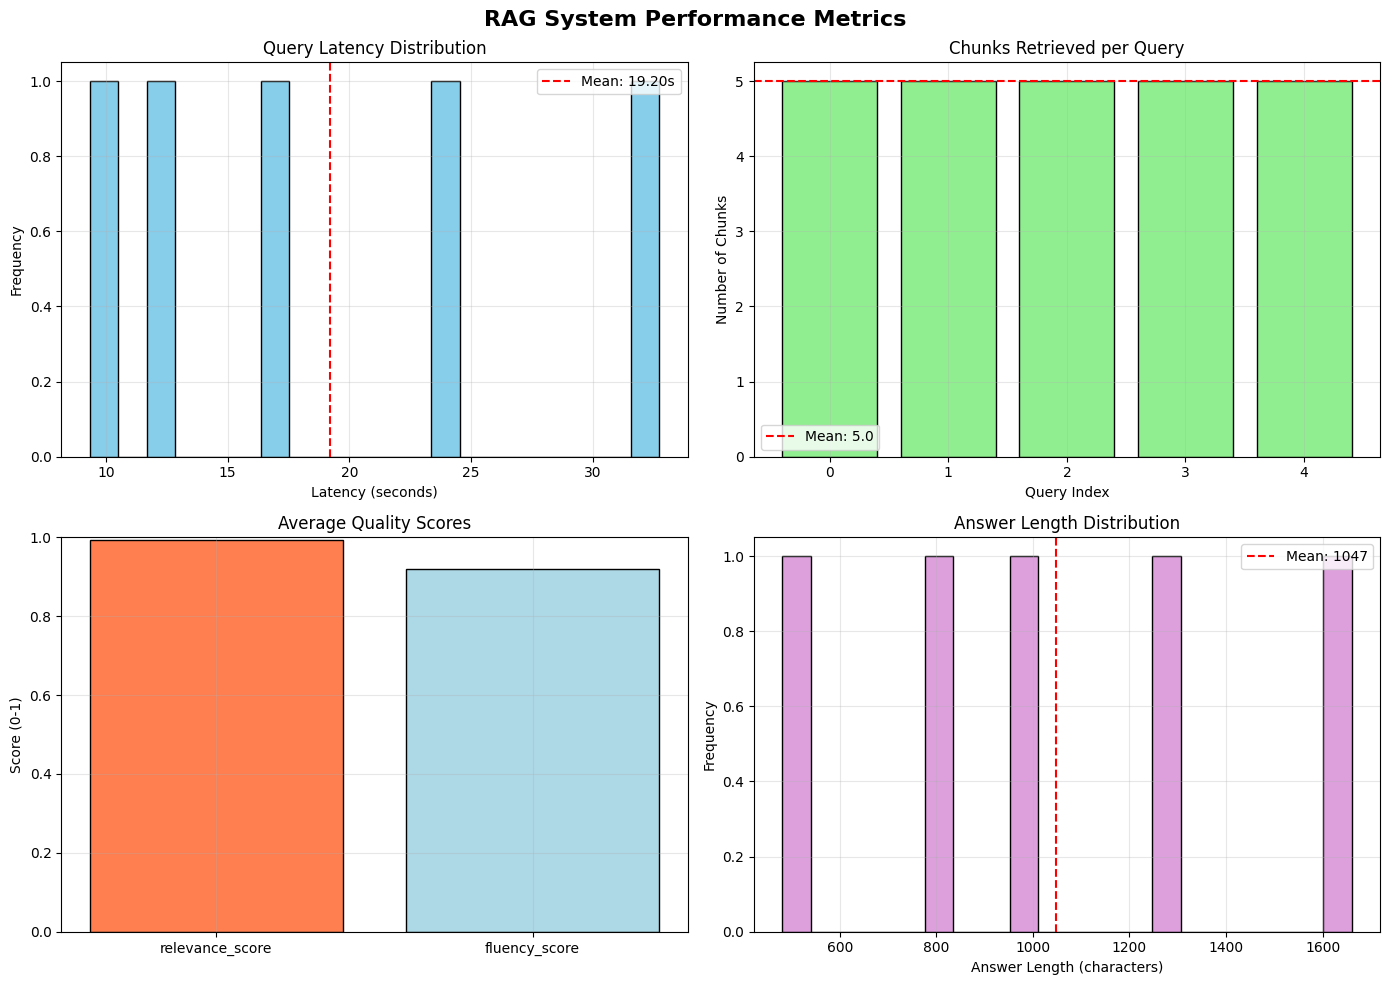

In [15]:
# Query
result = rag.query("What are the main topics?")
print(result["answer"])

# Benchmark
df = evaluator.benchmark_queries(SAMPLE_TEST_QUERIES)
evaluator.generate_performance_report()
evaluator.plot_performance_metrics()